In [110]:
import numpy as np
import pandas as pd
import os
#from osgeo import gdal
import geopandas as gpd
import rasterio
import osmnx as ox
import rioxarray
import pyproj
import shapely.geometry as sg
import networkx as nx

In [99]:
# Test data
test_path = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/"
single_point = gpd.read_file(test_path + "Test_single_home_location.gpkg")
multi_point = gpd.read_file(test_path + "Test_multiple_home_locations.gpkg")
polygon = gpd.read_file(test_path + "TestArea.gpkg")
ndvi = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
land_cover = rasterio.open(test_path + "Landcover_data_test.tif")

single_point_geographic = single_point.to_crs('epsg:4326')

# GREENNESS AVAILABILITY - MEAN NDVI

In [116]:
# QUESTION: CAN POI FILE CONTAIN BOTH POINTS AND POLYGONS?
def get_mean_NDVI(point_of_interest_file, ndvi_raster_file, buffer_dist=None, buffer_type=None, network_file=None):
    # Read and process user input, check conditions
    poi = gpd.read_file(point_of_interest_file)
    if not poi.crs.is_projected:
        raise ValueError("The CRS of the PoI dataset is currently geographic, please transform it into a local projected CRS and re-run the function")
    
    # Save EPSG code of study area
    epsg = poi.crs.to_epsg()

    ndvi_src = rioxarray.open_rasterio(ndvi_raster_file)
    if not ndvi_src.rio.crs.to_epsg() == epsg:
                    print("Adjusting CRS of NDVI file to match with Point of Interest CRS...")
                    print("Done")
                    ndvi_src.rio.write_crs(f'EPSG:{epsg}', inplace=True)

    # Make sure all points of interest are within the NDVI raster provided
    if not all(geom.within(sg.box(*ndvi_src.rio.bounds())) for geom in poi['geometry']):
        raise ValueError("Not all points of interest are within the NDVI file provided, please make sure they are and re-run the function")

    # Create buffers (or not) based on user input        
    if poi.iloc[0]['geometry'].geom_type == "Point":
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")
    
        if buffer_type == "euclidian":
            if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                raise TypeError("Please make sure that the buffer distance is set as a positive integer")             

            poi['aoi_geometry'] = poi['geometry'].buffer(buffer_dist)
        else:
            if network_file is not None and (not os.path.splitext(network_file)[1] == ".gpkg"):
                raise ValueError("Please provide the network file in '.gpkg' format")
            elif network_file is not None and (os.path.splitext(network_file)[1] == ".gpkg"):
                network = gpd.read_file(network_file, layer='edges') # QUESTION: ASSUME GPKG FORMAT?
            else:
                network = None

            if network is None:
                if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                    raise TypeError("Please make sure that the buffer distance is set as a positive integer")             
        
                epsg_transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326")

                # Transform the geometry column to lat-lon coordinates
                poi['latlon'] = poi.geometry.apply(lambda p: epsg_transformer.transform(p.x, p.y))

                # Create a new column with the OSM network graph for each point
                poi['graph'] = poi.latlon.apply(lambda ll: ox.graph_from_point(ll, network_type='all', dist=buffer_dist))

                # Retrieve only edges from the graph for each point
                poi['edges'] = poi.graph.apply(lambda g: ox.graph_to_gdfs(g, nodes=True, edges=True)[1])

                # Get the bounding box of all the edges, this will be the area of interest for each point
                poi['bbox_env'] = poi.edges.apply(lambda edges: edges.unary_union.convex_hull)

                # Transform bbox back to local projected crs
                poi['aoi_geometry'] = gpd.GeoDataFrame(geometry=poi.bbox_env, crs='EPSG:4326').to_crs(f'EPSG:{epsg}')['geometry']

                # Drop intermediate steps' columns
                poi.drop(['latlon', 'graph', 'edges', 'bbox_env'], axis=1, inplace=True)
            else:
                if not network.crs.to_epsg() == epsg:
                    print("Adjusting CRS of Network file to match with Point of Interest CRS...")
                    print("Done")
                    network.to_crs(f'EPSG:{epsg}', inplace=True)

                # Create bounding box for network file
                bbox_network = network.unary_union.convex_hull

                if not all(geom.within(bbox_network) for geom in poi['geometry']):
                     raise ValueError("Not all points of interest are within the network file provided, please make sure they are and re-run the function")

                poi['aoi_geometry'] = gpd.GeoDataFrame(geometry=[bbox_network], crs=f'EPSG:{epsg}')
    else:
        poi['aoi_geometry'] = poi['geometry']

    # Calculate mean NDVI values
    aoi_gdf = gpd.GeoDataFrame(geometry=poi['aoi_geometry'])
    poi['mean_NDVI'] = aoi_gdf.apply(lambda row: ndvi_src.rio.clip([row.geometry]).clip(min=0).mean().values.round(3), axis=1)

    return poi

In [119]:
get_mean_NDVI(point_of_interest_file=test_path + "Test_single_home_location.gpkg", ndvi_raster_file=test_path + "NDVI_data_test.tif", 
             buffer_dist=None, buffer_type="network", network_file = test_path + "test_network.gpkg")

Adjusting CRS of Network file to match with Point of Interest CRS...
Done


,id,geometry,aoi_geometry,mean_NDVI
0,NaN,POINT (387164.991 394443.414),"POLYGON ((387118.201 393932.690, 386744.592 39...",0.263


In [120]:
get_mean_NDVI(point_of_interest_file=test_path + "Test_multiple_home_locations.gpkg", ndvi_raster_file=test_path + "NDVI_data_test.tif", 
             buffer_dist=500, buffer_type="network")

,id,geometry,aoi_geometry,mean_NDVI
0,NaN,POINT (388644.249 392861.634),"POLYGON ((388888.440 392376.153, 388754.314 39...",0.351
1,NaN,POINT (385981.911 393805.494),"POLYGON ((386369.711 393308.987, 385862.678 39...",0.338
2,NaN,POINT (388631.230 395322.181),"POLYGON ((388594.369 394822.792, 388546.037 39...",0.359


# TESTING AREA

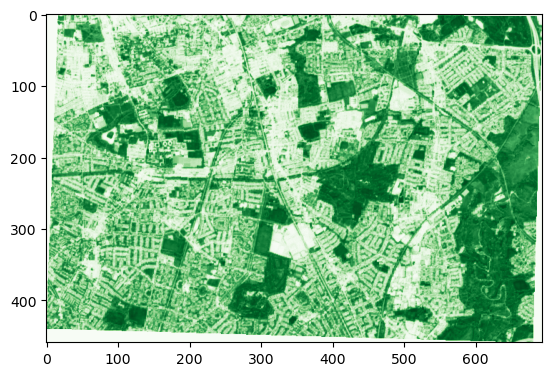

<Axes: >

In [34]:
from rasterio.plot import show
ndvi_read = rasterio.open(test_path + "NDVI_data_test.tif").read()
ndvi_read[ndvi_read<0]=0
show((ndvi_read), cmap='Greens')

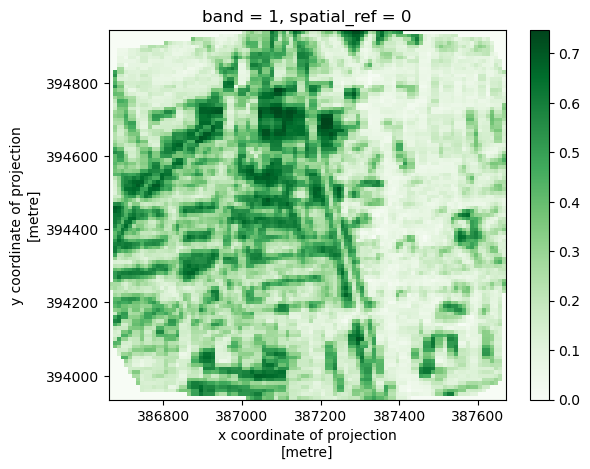

In [36]:
# Transforming projected coordinates to lat/lon to extract network buffer via osmnx
epsg = single_point.crs.to_epsg()
transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326")
x = transformer.transform(single_point['geometry'].x, single_point['geometry'].y)

G = ox.graph_from_point(x, network_type='all_private', dist=500)

#ox.plot_graph(G)

# Retrieve only edges from the graph
nodes_proj, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Get the bounding box of all the edges, this will be the area of interest for each point
bbox_env = edges.unary_union.convex_hull

# Transform bbox back to local projected crs
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_env], crs='EPSG:4326')
bbox_gdf = bbox_gdf.to_crs(f'EPSG:{epsg}')

# Test clipping of tif file based on network buffer geometries
ndvi_clip_test = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
ndvi_clip_test = ndvi_clip_test.clip(min=0)
ndvi_clipped = ndvi_clip_test.rio.clip(bbox_gdf['geometry']).clip(min=0)
ndvi_clipped.plot(cmap='Greens')

0.22761045


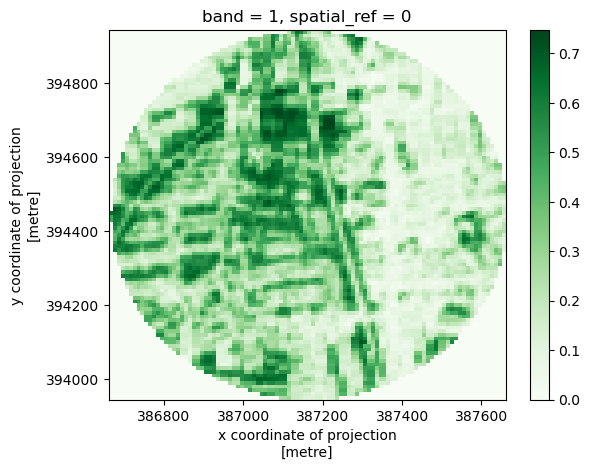

In [42]:
# Test clipping of tif file based on buffer geometries
single_point['aoi_geometry'] = single_point['geometry'].buffer(500)
buffer_clip = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
buffer_clip = buffer_clip.clip(min=0)
buffer_clipped = buffer_clip.rio.clip(single_point.aoi_geometry).clip(min=0)
print(buffer_clipped.mean().values)
buffer_clipped.plot(cmap='Greens')

In [90]:
# Perhaps include warning on the maximum radius of the provided tif file
test_2 = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
file_bounds = test_2.rio.bounds()

left, bottom, right, top = file_bounds

width = right - left
height = top - bottom
max_radius = min(width, height) / 2
max_radius

2295.0

In [60]:
# Write network to gpkg
epsg = single_point.crs.to_epsg()
transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326")
x = transformer.transform(single_point['geometry'].x, single_point['geometry'].y)

G = ox.graph_from_point(x, network_type='all', dist=500)

ox.save_graph_geopackage(G, filepath=test_path + 'test_network.gpkg')

0.26289955


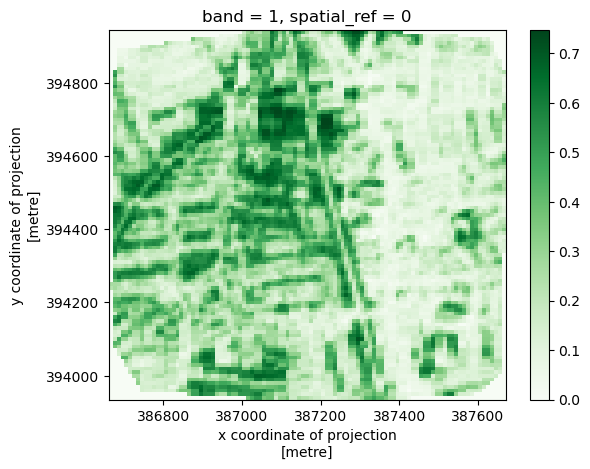

In [61]:
network_test = gpd.read_file(test_path + "test_network.gpkg", layer='edges')
network_test.to_crs('EPSG:27700', inplace=True)
network_test.crs

bbox_env = network_test.unary_union.convex_hull

# Transform bbox back to local projected crs
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_env], crs='EPSG:27700')

# Test clipping of tif file based on network buffer geometries
network_ndvi = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
network_ndvi = network_ndvi.clip(min=0)
network_clipped = network_ndvi.rio.clip(bbox_gdf['geometry']).clip(min=0)
print(network_clipped.mean().values)
network_clipped.plot(cmap='Greens')

In [ ]:
# FOR NETWORK PROVIDED BY USER 
# apply lambda function to points dataframe and store clipped polygons in new column
poi['aoi_geometry'] = poi.apply(lambda row: bbox_network.intersection(row.geometry.buffer(buffer_dist)), axis=1)

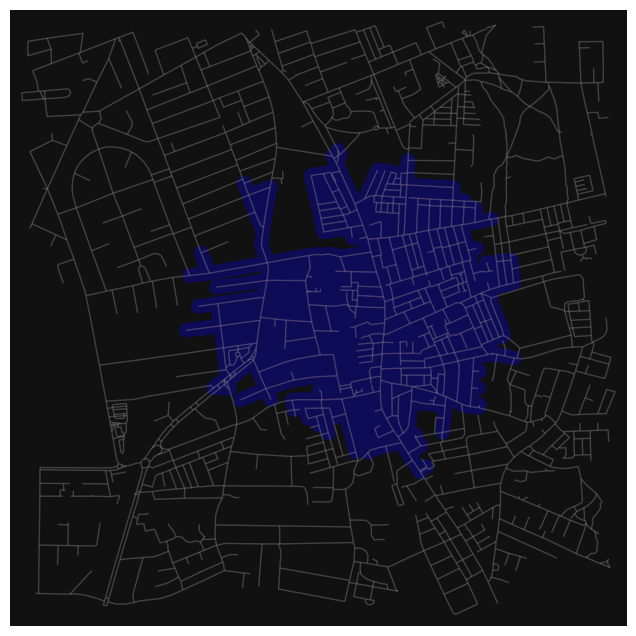

In [188]:
import matplotlib.pyplot as plt
%matplotlib inline

# configure the place, network type, trip times, and travel speed
network_type = "walk"
trip_times = [10]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

epsg = single_point.crs.to_epsg()
transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326")
place = transformer.transform(single_point['geometry'].x, single_point['geometry'].y)

G = ox.graph_from_point(place, network_type=network_type, dist=1000)

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)
graph_epsg = G.graph['crs'].to_epsg()

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [sg.Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", sg.LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = sg.Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys, crs=f"EPSG:{graph_epsg}")

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()


0.13437006


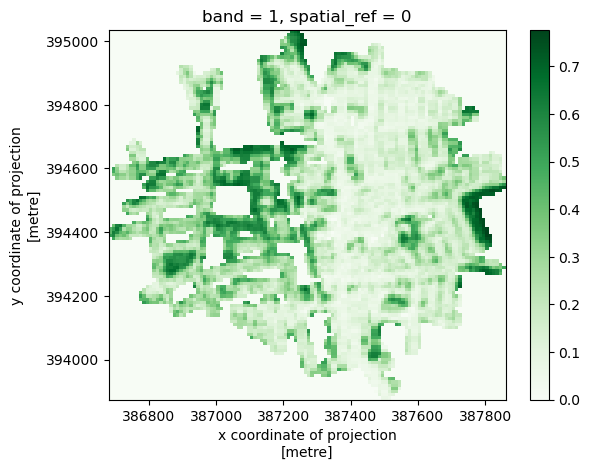

In [175]:
gdf.to_crs("EPSG:27700", inplace=True)

network_ndvi = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
network_ndvi = network_ndvi.clip(min=0)
network_clipped = network_ndvi.rio.clip(gdf.head(1)['geometry']).clip(min=0)
print(network_clipped.mean().values)
network_clipped.plot(cmap='Greens')

In [ ]:
# configure the place, network type, trip times, and travel speed
network_type = "walk"
trip_time = 10  # in minutes
travel_speed = 4.5  # walking speed in km/hour

epsg = single_point.crs.to_epsg()
transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326")
place = transformer.transform(single_point['geometry'].x, single_point['geometry'].y)

G = ox.graph_from_point(place, network_type=network_type, dist=1000)

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)
graph_epsg = G.graph['crs'].to_epsg()

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

def make_iso_poly(G, edge_buff=25, node_buff=50):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

    node_points = [sg.Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index("id")

    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", sg.LineString([f, t]))
        edge_lines.append(edge_lookup)

    n = nodes_gdf.buffer(node_buff).geometry
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
    all_gs = list(n) + list(e)
    isochrone_poly = gpd.GeoSeries(all_gs).unary_union

    # try to fill in surrounded areas so shapes will appear solid and
    # blocks without white space inside them
    isochrone_poly = sg.Polygon(isochrone_poly.exterior)
    
    return isochrone_poly


# make the isochrone polygons
isochrone_poly = make_iso_poly(G, edge_buff=25, node_buff=0)
gdf = gpd.GeoDataFrame(geometry=[isochrone_poly], crs=f"EPSG:{graph_epsg}")
